## We did Data Processing before, in predict_gas
- Three datasets are used:
  -  makeup: Monthly composition of gasoline prices (e.g. Refining, Taxes).
  - gas_prices: Weekly gasoline retail prices.
  - brent: Daily crude oil prices.
- Alignment of time frequencies:
  - Monthly makeup data is interpolated to weekly values using linear interpolation.
  - Daily brent prices are aggregated to weekly averages.
  - The result  **gas_brent_linear** is a weekly-aligned dataset with: Weekly gas prices, Weekly estimates of the components (Refining, Taxes, etc.), Weekly Brent crude oil averages.

In [1]:
import pandas as pd
gas_data = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv", index_col=0)
gas_data = gas_data.rename(columns={"Price": "Gas_Price"})
gas_data.columns

Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Gas_Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

In [ ]:
stock_data = pd.read_csv("datathon data/all_stocks_and_etfs.csv")
stock_data.columns


Index(['Date-Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker_Symbol'], dtype='object')

### Feature Engineering

Computes log-returns and percentage changes for:
- Retail gasoline prices,
- Each price component (Refining, Taxes, etc.),
- Crude oil prices.
- Generates lagged features (e.g., previous 1 to 4 months' returns) to examine delayed effects.

In [3]:
import numpy as np
for col in ['Gas_Price', 'Brent_Price', 'Refining', 'Taxes', 'Distribution_and_Marketing', 'Crude_Oil']:
    gas_data[f'{col}_logreturn'] = np.log(gas_data[col] / gas_data[col].shift(1))
    gas_data[f'{col}_pct'] = gas_data[col].pct_change()
lag = 1
gas_data[f'Gas_Price_lag_{lag}'] = gas_data['Gas_Price'].shift(lag)
gas_data = gas_data.dropna()
gas_data

/home/love/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/love/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Year,Type,Type_Clean,Unit,Geography,Gas_Price,Month,Refining,Distribution_and_Marketing,...,Brent_Price_pct,Refining_logreturn,Refining_pct,Taxes_logreturn,Taxes_pct,Distribution_and_Marketing_logreturn,Distribution_and_Marketing_pct,Crude_Oil_logreturn,Crude_Oil_pct,Gas_Price_lag_1
1,2000-01-10,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.264,1,9.82,11.90,...,-0.071677,0.230297,0.258974,-0.012539,-0.012461,-0.088411,-0.084615,-0.010672,-0.010616,1.272
2,2000-01-17,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.277,1,11.84,10.80,...,0.064769,0.187063,0.205703,-0.012699,-0.012618,-0.096992,-0.092437,-0.010788,-0.010730,1.264
3,2000-01-24,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.315,1,13.86,9.70,...,0.064031,0.157523,0.170608,-0.012862,-0.012780,-0.107420,-0.101852,-0.010905,-0.010846,1.277
4,2000-01-31,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.316,1,15.88,8.60,...,0.015496,0.136053,0.145743,-0.013030,-0.012945,-0.120364,-0.113402,-0.011025,-0.010965,1.315
5,2000-02-07,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.325,2,17.90,7.50,...,0.018667,0.119740,0.127204,-0.013202,-0.013115,-0.136859,-0.127907,-0.011148,-0.011086,1.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2023-11-27,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.238,11,8.25,19.45,...,-0.010910,0.006079,0.006098,0.014185,0.014286,-0.002567,-0.002564,-0.003540,-0.003534,3.289
1248,2023-12-04,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.231,12,8.30,19.40,...,-0.002720,0.006042,0.006061,0.013986,0.014085,-0.002574,-0.002571,-0.003552,-0.003546,3.238
1249,2023-12-11,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.136,12,8.30,19.40,...,-0.063833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.231
1250,2023-12-18,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.053,12,8.30,19.40,...,0.009351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.136


In [4]:
gas_data["Date"] = pd.to_datetime(gas_data["Date"])
stock_data["Date"] = pd.to_datetime(stock_data["Date-Time"])

label_col = 'Close_logreturn' #'Close_diff'
stock_data[label_col] = np.log(stock_data['Close'] / stock_data['Close'].shift(lag)) #stock_data['Close'] - stock_data['Close'].shift(1)
stock_data[f'Close_lag_{lag}'] = stock_data['Close'].shift(lag)

stock_data = stock_data[["Date", "Ticker_Symbol", f'Close_lag_{lag}', label_col]]
stock_data

,Date,Ticker_Symbol,Close_lag_1,Close_logreturn
0,2024-01-25,HAL,NaN,NaN
1,2024-01-24,HAL,37.0000,-0.004605
2,2024-01-23,HAL,36.8300,-0.042430
3,2024-01-22,HAL,35.3000,-0.024955
4,2024-01-19,HAL,34.4300,-0.013450
...,...,...,...,...
144553,1999-11-05,SPY,138.0000,-0.000906
144554,1999-11-04,SPY,137.8750,-0.009794
144555,1999-11-03,SPY,136.5312,-0.007582
144556,1999-11-02,SPY,135.5000,-0.006711


align time between the 2datasets:

In [5]:
df = pd.merge(
    left=stock_data,
    right=gas_data,
    on="Date",
    how="inner"
)
df = df.dropna()
df.to_csv("datathon data/stock_data.csv", index=False)
df

,Date,Ticker_Symbol,Close_lag_1,Close_logreturn,Year,Type,Type_Clean,Unit,Geography,Gas_Price,...,Brent_Price_pct,Refining_logreturn,Refining_pct,Taxes_logreturn,Taxes_pct,Distribution_and_Marketing_logreturn,Distribution_and_Marketing_pct,Crude_Oil_logreturn,Crude_Oil_pct,Gas_Price_lag_1
0,2023-12-18,HAL,36.8200,-0.016706,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.053,...,0.009351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.136
1,2023-12-11,HAL,34.4400,0.009536,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.136,...,-0.063833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.231
2,2023-12-04,HAL,36.3300,0.028224,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.231,...,-0.002720,0.006042,0.006061,0.013986,0.014085,-0.002574,-0.002571,-0.003552,-0.003546,3.238
3,2023-11-27,HAL,37.5200,0.004521,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.238,...,-0.010910,0.006079,0.006098,0.014185,0.014286,-0.002567,-0.002564,-0.003540,-0.003534,3.289
4,2023-11-20,HAL,38.2100,-0.000262,2023,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,3.289,...,-0.013466,0.006116,0.006135,0.014389,0.014493,-0.002561,-0.002558,-0.003527,-0.003521,3.349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26670,2000-02-14,SPY,141.0781,-0.011249,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.356,...,0.005090,-0.035540,-0.034916,-0.023530,-0.023256,0.162686,0.176667,0.000000,0.000000,1.325
26671,2000-02-07,SPY,144.3125,-0.013517,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.325,...,0.018667,0.119740,0.127204,-0.013202,-0.013115,-0.136859,-0.127907,-0.011148,-0.011086,1.316
26672,2000-01-31,SPY,140.9375,-0.009804,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.316,...,0.015496,0.136053,0.145743,-0.013030,-0.012945,-0.120364,-0.113402,-0.011025,-0.010965,1.315
26673,2000-01-24,SPY,141.9375,-0.011292,2000,Regular All Formulations Retail Gasoline Price...,Regular All Formulations Retail Gasoline Prices,Dollars per Gallon,US,1.315,...,0.064031,0.157523,0.170608,-0.012862,-0.012780,-0.107420,-0.101852,-0.010905,-0.010846,1.277


In [6]:
codes, uniques = pd.factorize(df["Ticker_Symbol"])
df["Ticker_Symbol"] = codes + 1

num_to_stock = {code + 1: symbol for code, symbol in enumerate(uniques)}
stock_to_num = {symbol: code + 1 for code, symbol in enumerate(uniques)}
print(num_to_stock)
print(stock_to_num)

{1: 'HAL', 2: 'FANG', 3: 'E', 4: 'EXC', 5: 'HES', 6: 'BKR', 7: 'BPT', 8: 'VLO', 9: 'CVX', 10: 'OXY', 11: 'KMI', 12: 'PSX', 13: 'NOV', 14: 'CHK', 15: 'MPC', 16: 'DVN', 17: 'COP', 18: 'EPD', 19: 'BP', 20: 'XOM', 21: 'EOG', 22: 'CEO', 23: 'SLB', 24: 'WMB', 25: 'ONEQ', 26: 'DIA', 27: 'VOO', 28: 'SPY'}
{'HAL': 1, 'FANG': 2, 'E': 3, 'EXC': 4, 'HES': 5, 'BKR': 6, 'BPT': 7, 'VLO': 8, 'CVX': 9, 'OXY': 10, 'KMI': 11, 'PSX': 12, 'NOV': 13, 'CHK': 14, 'MPC': 15, 'DVN': 16, 'COP': 17, 'EPD': 18, 'BP': 19, 'XOM': 20, 'EOG': 21, 'CEO': 22, 'SLB': 23, 'WMB': 24, 'ONEQ': 25, 'DIA': 26, 'VOO': 27, 'SPY': 28}


### Train XGBoost and Random Forest

**Aim**: build a predictive model for stock (log-return or pct change).


**Approach**:
- Use XGBoost for prediction.
- Extract feature importances to assess which factors matter most.

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
feature_cols = [col for col in df.columns if (col == f'Close_lag_{lag}' or col == 'Ticker_Symbol' or '_logreturn' in col) and col != label_col]
print(feature_cols)
X = df[feature_cols]
y = df[label_col]

print(X)
print(y)

['Ticker_Symbol', 'Close_lag_1', 'Gas_Price_logreturn', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
       Ticker_Symbol  Close_lag_1  Gas_Price_logreturn  Brent_Price_logreturn  \
0                  1      36.8200            -0.026823               0.009308   
1                  1      34.4400            -0.029844              -0.065961   
2                  1      36.3300            -0.002164              -0.002724   
3                  1      37.5200            -0.015628              -0.010970   
4                  1      38.2100            -0.018078              -0.013557   
...              ...          ...                  ...                    ...   
26670             28     141.0781             0.023127               0.005077   
26671             28     144.3125             0.006816               0.018495   
26672             28     140.9375             0.000760               0.015377   
26673

In [9]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X = pd.DataFrame(
    std_scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

y = pd.Series(
    std_scaler.fit_transform(y.values.reshape(-1, 1)).ravel(),
    index=y.index,
    name=y.name
)

print(X)
print(y)

# from scipy.stats import zscore
# X = X.apply(zscore, axis=0, ddof=0)      # DataFrame → each column z-scored
# y = zscore(y, ddof=0)                    # Series → array of z-scores


# def scale_to_minus1_plus1(df: pd.DataFrame) -> pd.DataFrame:
#     return 2 * (df - df.min()) / (df.max() - df.min()) - 1

# X = scale_to_minus1_plus1(X)
# y = scale_to_minus1_plus1(y.to_frame()).iloc[:, 0]

       Ticker_Symbol  Close_lag_1  Gas_Price_logreturn  Brent_Price_logreturn  \
0          -1.692178    -0.606288            -1.284452               0.184036   
1          -1.692178    -0.642031            -1.428256              -1.380278   
2          -1.692178    -0.613647            -0.110323              -0.066020   
3          -1.692178    -0.595775            -0.751378              -0.237391   
4          -1.692178    -0.585412            -0.868058              -0.291166   
...              ...          ...                  ...                    ...   
26670       1.608008     0.959485             1.093883               0.096118   
26671       1.608008     1.008060             0.317243               0.374970   
26672       1.608008     0.957373             0.028917               0.310175   
26673       1.608008     0.972391             1.388918               1.280479   
26674       1.608008     1.010875            -0.307684              -1.555155   

       Refining_logreturn  

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))

ypredtrain = model.predict(X_train)
print("Train MSE:", mean_squared_error(y_train, ypredtrain))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

Test MSE: 0.49251503840173483
Train MSE: 0.28503623016995233
Feature Importantce                                 feature  importance
3                 Brent_Price_logreturn    0.175493
4                    Refining_logreturn    0.163457
5                       Taxes_logreturn    0.144693
6  Distribution_and_Marketing_logreturn    0.133558
7                   Crude_Oil_logreturn    0.126159
2                   Gas_Price_logreturn    0.125658
0                         Ticker_Symbol    0.068504
1                           Close_lag_1    0.062477


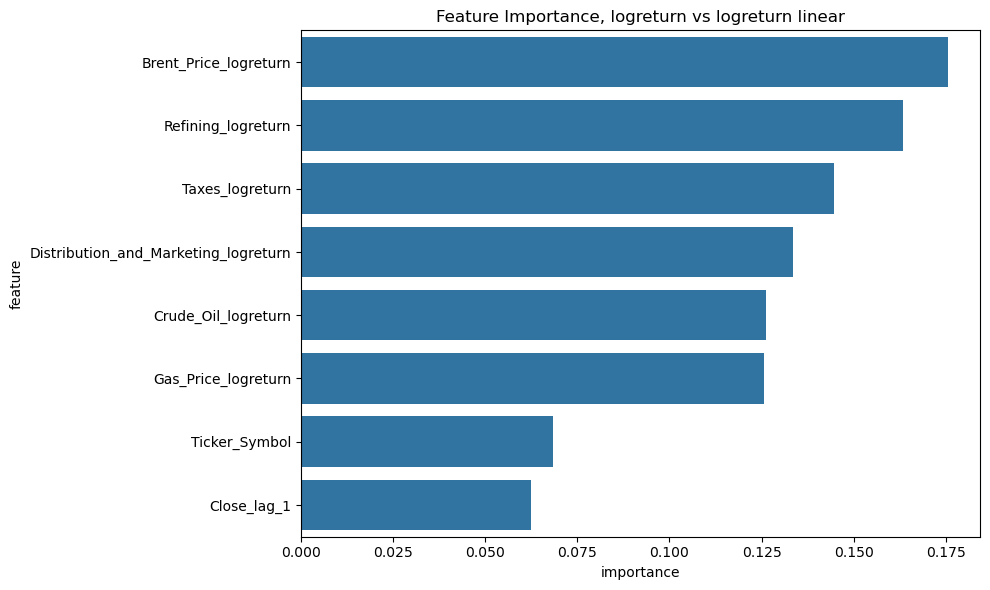

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.title("Feature Importance, logreturn vs logreturn linear")
plt.tight_layout()
plt.show()

In [12]:
# install with: pip install pytorch_tabnet
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.metrics import mean_squared_error

# Assume X, y are your feature matrix and target (numpy or pandas)
# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values.reshape(-1,1),
    test_size=0.2, random_state=42
)

# 2) Initialize TabNet for regression
#    key params: n_d/n_steps adjust model capacity
model = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax'  # or 'entmax'
)

# 3) Fit
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train','test'],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 4) Predict & evaluate
y_pred = model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))

# 5) Extract global feature importances
#    attribute `feature_importances_` is a numpy array of shape (n_features,)
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("TabNet Feature Importances:\n", feat_imp.head(10))


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66155 | train_rmse: 1.16319 | test_rmse: 1.27564 |  0:00:01s
epoch 1  | loss: 1.01972 | train_rmse: 0.97959 | test_rmse: 1.06033 |  0:00:03s
epoch 2  | loss: 0.95978 | train_rmse: 0.96714 | test_rmse: 1.05095 |  0:00:04s
epoch 3  | loss: 0.93604 | train_rmse: 0.95909 | test_rmse: 1.03938 |  0:00:06s
epoch 4  | loss: 0.92736 | train_rmse: 0.95709 | test_rmse: 1.03985 |  0:00:07s
epoch 5  | loss: 0.92021 | train_rmse: 0.95377 | test_rmse: 1.04136 |  0:00:09s
epoch 6  | loss: 0.90866 | train_rmse: 0.95015 | test_rmse: 1.03804 |  0:00:10s
epoch 7  | loss: 0.90737 | train_rmse: 0.9513  | test_rmse: 1.04241 |  0:00:12s
epoch 8  | loss: 0.91184 | train_rmse: 0.94659 | test_rmse: 1.03232 |  0:00:13s
epoch 9  | loss: 0.90532 | train_rmse: 0.94711 | test_rmse: 1.03504 |  0:00:15s
epoch 10 | loss: 0.90429 | train_rmse: 0.94976 | test_rmse: 1.0355  |  0:00:17s
epoch 11 | loss: 0.91262 | train_rmse: 0.95145 | test_rmse: 1.04081 |  0:00:19s
epoch 12 | loss: 0.91096 | train_rmse: 0

/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test MSE: 1.0656781515784441
TabNet Feature Importances:
                                 feature  importance
0                   Gas_Price_logreturn    0.218700
1                       Taxes_logreturn    0.212371
2                 Brent_Price_logreturn    0.152553
3                   Crude_Oil_logreturn    0.100608
4                           Close_lag_1    0.090556
5  Distribution_and_Marketing_logreturn    0.081304
6                         Ticker_Symbol    0.079562
7                    Refining_logreturn    0.064346


In [13]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1,1),
                                                    test_size=0.2, random_state=42)

model = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5, gamma=1.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 2e-2, 'weight_decay': 1e-5},
    mask_type='sparsemax',
    verbose=10
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train','test'],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
    compute_importance=True 
)

y_pred = model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))

feat_imp = (
    pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("TabNet Feature Importances:\n", feat_imp)


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20055 | train_rmse: 0.96992 | test_rmse: 1.04713 |  0:00:03s
epoch 10 | loss: 0.93301 | train_rmse: 0.96617 | test_rmse: 1.04876 |  0:00:40s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_test_rmse = 1.03627


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test MSE: 1.0738541570673898
TabNet Feature Importances:
                                 feature  importance
0                       Taxes_logreturn    0.318349
1                   Crude_Oil_logreturn    0.271726
2                 Brent_Price_logreturn    0.142065
3                   Gas_Price_logreturn    0.082853
4                    Refining_logreturn    0.074566
5  Distribution_and_Marketing_logreturn    0.052723
6                         Ticker_Symbol    0.040801
7                           Close_lag_1    0.016917
